In [1]:
# Import the required packages
import numpy as np
# from numpy.linalg import svd as svd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
# from collections import OrderedDict
import matplotlib.pyplot as plt

# Define plot font sizes
label_font = 18
title_font = 24
legend_font = 12


# RNN Model Class - Classical Conditioning

In [2]:
class DrosophilaRNN(nn.Module):
    def __init__(self, *, n_kc=200, n_mbon=20, n_fbn=60, n_ext=2, n_out=1, n_seed=None):
        super().__init__()
        # Set the seeds
        if n_seed is not None:
            np.random.seed(n_seed)
            torch.manual_seed(n_seed)
        # Set constants
        W_KC_MBON_max = 0.05
        self.KC_MBON_min = 0. # Minimum synaptic weight
        self.KC_MBON_max = W_KC_MBON_max # Maximum synaptic weight
#         self.W_KC_MBON_0 = Variable(torch.ones((self.N_MBON, self.N_KC)) * W_KC_MBON_max, requires_grad=False)
        self.W_KC_MBON_0 = Variable(torch.ones((n_mbon, n_kc)) * W_KC_MBON_max, requires_grad=False)
        self.tau_w = 5  # Time scale of KC->MBON LTD/LTP (plasticity)
        self.tau_r = 1  # Time scale of output circuitry activity
        self.n_int = 1  # Number of task intervals
        # Set the sizes of layers
        n_dan = n_mbon
        self.N_KC = n_kc
        self.N_MBON = n_mbon
        self.N_FBN = n_fbn
        self.N_DAN = n_dan
        self.N_recur = n_mbon + n_fbn + n_dan
        self.N_ext = n_ext
        self.N_out = n_out
        # Define network variables used to store data
        self.train_odors = None
        self.test_odors = None
        # Define updatable network parameters
        sqrt2 = torch.sqrt(torch.tensor(2, dtype=torch.float))
        mean_MBON = torch.zeros((self.N_recur, n_mbon))
        mean_FBN = torch.zeros((self.N_recur, n_fbn))
        mean_DAN = torch.zeros((self.N_recur, n_dan))
        W_MBON = torch.normal(mean_MBON, torch.sqrt(1 / (sqrt2 * n_mbon)),
                              generator=n_seed)
        W_FBN = torch.normal(mean_FBN, torch.sqrt(1 / (sqrt2 * n_fbn)),
                             generator=n_seed)
        W_DAN = torch.normal(mean_DAN, torch.sqrt(1 / (sqrt2 * n_dan)),
                             generator=n_seed)
        self.W_recur = nn.Parameter(torch.cat((W_MBON, W_FBN, W_DAN), dim=1),
                                    requires_grad=True)
        self.W_ext = nn.Parameter(torch.randn(n_fbn, n_ext),
                                  requires_grad=True)
        mean_readout = torch.zeros((n_out, n_mbon))
        std_readout = 1 / torch.sqrt(torch.tensor(n_mbon, dtype=torch.float))
        self.W_readout = nn.Parameter(torch.normal(mean_readout, std_readout,
                                                   generator=n_seed),
                                      requires_grad=True)
        self.bias = nn.Parameter(torch.ones(self.N_recur) * 0.1,
                                 requires_grad=True)
        self.beta = nn.Parameter(torch.ones(n_kc) * 0.01,
                                 requires_grad=True)

    def forward(self, r_KC, r_ext, time, n_batch, W0, r0=None, **kwargs):
        """ Defines the forward pass of the RNN

        The KC->MBON weights are constrained to the range [0, 0.05].
        MBONs receive external input from Kenyon cells (r_KC i.e. 'odors').
        Feedback neurons (FBNs) receive external input (r_ext i.e. 'context').
        DAN->MBON weights are permanently set to zero.
        DANs receive no external input.

        Inputs
            r_KC = activity of the Kenyon cell inputs (representing odors)
            r_ext = context inputs (representing the conditioning context)
            time = time vector for a single interval
            n_batch = number of trials in mini-batch
            W0 = initial weights for KC->MBON connections
            r0 = initial activities for output circuitry neurons

        Returns
            r_recur: list of torch.ndarray(batch_size, N_MBON + N_FBN + N_DAN)
                = time series of activities in the output circuitry
            Wt: list of torch.ndarray(batch_size, N_recur, N_recur)
                = time series of KC->MBON weights (dopaminergic plasticity)
            readout: list of torch.ndarray(batch_size, 1)
                = time series of valence readouts (behaviour)
        """

        # Define the time step of the simulation
        dt = np.diff(time)[0]

        # Initialize output circuit firing rates for each trial
        if r0 is not None:
            r_init = r0
        else:
            r_init = torch.ones(n_batch, self.N_recur) * 0.1
            r_init[:, :self.N_MBON] = 0
        r_recur = [r_init]

        # Initialize the eligibility traces and readout
        r_bar_KC = r_KC[:, :, 0]
        r_bar_DAN = r_recur[-1][:, -self.N_DAN:]
        readout = [torch.einsum('bom, bm -> bo',
                                self.W_readout.repeat(n_batch, 1, 1),
                                r_recur[-1][:, :self.N_MBON]).squeeze()]

        # Set the weights DAN->MBON to zero
        W_recur = self.W_recur.clone()
        W_recur[:self.N_MBON, -self.N_DAN:] = 0

        # Set the KC->MBON weights
        W_KC_MBON, wt = W0

        # Update activity for each time step
        for t in range(time.shape[0] - 1):
            # Define the input to the output circuitry
            I_KC_MBON = torch.einsum('bmk, bk -> bm',
                                     W_KC_MBON, r_KC[:, :, t])
            I_FBN = torch.einsum('bfe, be -> bf',
                                 self.W_ext.repeat(n_batch, 1, 1),
                                 r_ext[:, :, t])
            I_tot = torch.zeros((n_batch, self.N_recur))
            I_tot[:, :self.N_MBON] = I_KC_MBON
            I_tot[:, self.N_MBON:self.N_MBON + self.N_FBN] = I_FBN

            # Update the output circuitry activity (see Eq. 1)
            Wr_prod = torch.einsum('bsr, br -> bs',
                                   W_recur.repeat(n_batch, 1, 1),
                                   r_recur[-1])
            dr = (-r_recur[-1] + F.relu(Wr_prod + self.bias.repeat(n_batch, 1)
                                        + I_tot)) / self.tau_r
            r_recur.append(r_recur[-1] + dr * dt)

            # Update KC->MBON plasticity variables
            out = self.wt_update(W_KC_MBON, wt, dt, r_bar_KC, r_bar_DAN,
                                 r_KC[:, :, t], r_recur[-1][:, -self.N_DAN:],
                                 n_batch, **kwargs)
            W_KC_MBON, wt, r_bar_KC, r_bar_DAN = out

            # Calculate the readout (see Eq. 2)
            readout.append(torch.einsum('bom, bm -> bo',
                                        self.W_readout.repeat(n_batch, 1, 1),
                                        r_recur[-1][:, :self.N_MBON]).squeeze())

        return r_recur, (W_KC_MBON, wt), readout

    def wt_update(self, W_KC_MBON, wt, dt, r_bar_KC, r_bar_DAN, r_KC, r_DAN,
                  n_batch, **kwargs):
        """ Updates the KC->MBON plasticity variables

        Synaptic weights from the Kenyon cells to the mushroom body output neurons
        (MBONs) are updated dynamically. All other weights are network parameters.
        The synaptic connections between Kenyon Cells (KCs) and MBONs are updated
        using a LTP/LTD rule (see Figure 1B of Jiang 2020), which models dopamine-
        gated neural plasticity on short time scale (behavioural learning).

        Parameters
            W_KC_MBON: list = KC->MBON weight matrices
            wt = dynamic plasticity update
            dt = time step of simulation
            r_bar_KC = eligibility trace of Kenyon cell activity
            r_bar_DAN = eligibility trace of dopaminergic cell activity
            r_KC = current activity of Kenyon cells
            r_DAN = current activity of dopamine cells
            n_batch = number of trials in mini-batch
        """

        # Calculate the eligibility traces (represent LTP/LTD)
        r_bar_KC = r_bar_KC + (r_KC - r_bar_KC) * dt / self.tau_w
        r_bar_DAN = r_bar_DAN + (r_DAN - r_bar_DAN) * dt / self.tau_w
        # Update the dynamic weight variable
        dw = self.calc_dw(r_bar_KC, r_bar_DAN, r_KC, r_DAN, n_batch, **kwargs)
        wt += dw * dt
        # Update the KC->MBON weights (see Eq. 8)
        dW = (-W_KC_MBON + wt) / self.tau_w
        W_tp1 = W_KC_MBON + dW * dt
        # Clip the KC->MBON weights to the range [0, 0.05]
        W_KC_MBON = torch.clamp(W_tp1, self.KC_MBON_min, self.KC_MBON_max)

        return W_KC_MBON, wt, r_bar_KC, r_bar_DAN

    def calc_dw(self, r_bar_KC, r_bar_DAN, r_KC, r_DAN, n_batch, nps=True, **kwargs):
        """ Calculates the dynamic weight update (see Eq 4).

        Parameters
            r_bar_KC = eligibility trace of Kenyon cell activity
            r_bar_DAN = eligibility trace of dopaminergic cell activity
            r_KC = current activity of Kenyon cells
            r_DAN = current activity of dopamine cells
            n_batch = number of trials in mini-batch
            nps = indicates whether non-specific potentiation is included

        Returns
            update to dynamic plasticity variables wt
        """

        # Calculate the LTD/LTP terms
        prod1 = torch.einsum('bd, bk -> bdk', r_bar_DAN, r_KC)
        prod2 = torch.einsum('bd, bk -> bdk', r_DAN, r_bar_KC)
        
        # Include non-specific potentiation (unless control condition)
        if nps:
            # Rectify the potentiation parameter
            beta = F.relu(self.beta.clone())
            # Constrain the potentiation parameter to be positive
            prod3 = torch.einsum('bd, bk -> bdk', r_bar_DAN,
                                 beta.repeat(n_batch, 1))
        else:
            prod3 = torch.zeros_like(prod2)
            
        return prod1 - prod2 + prod3
        
    def train_net(self, *, opti, T_int=200, T_stim=2, dt=0.5, n_epoch=5000, n_batch=30, clip=0.001, **kwargs):
        """ Trains a network on classical conditioning tasks.

        Tasks include first-order or second-order conditioning, and extinction.
        Tasks consist of two (first-order) or three (second-order and extinction)
        intervals. Each task has its own input generating function. Stimuli are
        presented between 5-15s of each interval. Neuron activities are reset
        between intervals to prevent associations being represented through
        persistent activity.

        Parameters
            opti = RNN network optimizer
            T_int = length of task intervals
            T_stim = length of time each stimulus is presented
            dt = time step of simulations
            n_epoch = number of epochs to train over
            n_batch = number of trials in mini-batch
            clip = maximum gradient allowed during training

        Returns
            r_out_epoch = output circuit neuron activities for final epoch
            Wt_epoch = KC->MBON weights for final epoch
            vt_epoch = readout (i.e. valence) for final epoch
            vt_opt = target valence for final epoch
            loss_hist = list of losses for all epochs
            ls_stims = list of stimulus time series for plotting
        """

        # Interval time vector
        time_int = torch.arange(0, T_int + dt/10, dt)

        # Generate a list of stimulus presentation times
        stim_times = self.gen_stim_times(T_stim, T_int, dt, n_epoch, n_batch,
                                         **kwargs)
        # Length of stimulus in indices
        stim_len = int(T_stim / dt)

        # List to store losses
        loss_hist = []
        
        # Initialize the KC-MBON weights
        W_KC_MBON = None

        for epoch in range(n_epoch):
            # Lists to store activities, weights, readouts and target valences
            r_outs = []
#             Wts = []
            vts = []

            # Set the intial KC->MBON weight values for each trial
            Wt, wt = self.init_w_kc_mbon(W_KC_MBON, n_batch, (epoch, n_epoch))
            W_KC_MBON = (Wt.detach(), wt.detach())

            # Generate odor (r_KC), context (r_ext), and target valence (vt_opt)
            st_epoch = stim_times[epoch]
            net_inputs = self.gen_inputs(st_epoch, stim_len, time_int.shape[0], 
                                         n_batch, **kwargs)
            r_KC, r_ext, vt_opt, ls_stims = net_inputs

            # For each interval in the task
            for i in range(self.n_int):
                # Run the forward model
                net_outs = self(r_KC[i], r_ext[i], time_int, n_batch, W_KC_MBON)
                # Set the initial KC->MBON weights for the next interval
                W_KC_MBON = net_outs[1]

                # Append the interval outputs to lists
                r_outs += net_outs[0]
#                 Wts += net_outs[1][0]
                vts += net_outs[2]

            # Concatenate the activities, weights and valences
            r_out_epoch = torch.stack(r_outs, dim=-1)
#             Wt_epoch = torch.stack(Wts, dim=-1)
            vt_epoch = torch.stack(vts, dim=-1)

            # Calculate the loss
            loss = cond_loss(vt_epoch, vt_opt, r_out_epoch[:, -self.N_DAN:, :])

            # Update the network parameters
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.parameters(), clip)
            optimizer.step()

            # Print an update
            if epoch % 500 == 0:
                print(epoch, loss.item())
            loss_hist.append(loss.item())

#         return r_out_epoch, Wt_epoch, vt_epoch, vt_opt, loss_hist, ls_stims
        return r_out_epoch, vt_epoch, vt_opt, loss_hist, ls_stims

    def init_w_kc_mbon(self, W_in, n_batch, e_tup):
        """ Initializes the KC->MBON weights for the task.
        
        KC->MBON weights are reset at the beginning of each epoch.

        Parameters
            W0 = specified initial weight values or None
            n_batch = number of trials in mini-batch
            e_tup: tuple = (current epoch, total training epochs)

        Returns
            W_KC_MBON: list = initial KC->MBON weight matrix
            wt = initial dynamic plasticity update
        """

#         wt0 = torch.ones(n_batch, self.N_MBON, self.N_KC) * self.KC_MBON_max
        wt0 = self.W_KC_MBON_0.repeat(n_batch, 1, 1)
        if W_in is None:
            W_in = (wt0.clone(), wt0.clone())
        # Calculate the saturation parameter and modify initial weights
        x_sat = min(1, (e_tup[0] / (e_tup[1] / 2)))
#         Wt = (1 - x_sat) * wt0 + x_sat * W_in[0].detach()
        wt = wt0.clone()
#         Wt = W_in[0].detach()
#         wt = (1 - x_sat) * wt0 + x_sat * W_in[1].detach()
        Wt = W_in[0]
#         wt = (1 - x_sat) * wt0 + x_sat * W_in[1]
#         wt = W_in[1]
        W_in = (Wt, wt)

        return W_in

    def gen_stim_times(self, T_stim, T_int, dt, n_epoch, n_batch, n_odors=4, **kwargs):
        """ Generates an array of stimulus presentation times for all trials

        Parameters
            T_stim = length of time each stimulus is presented
            T_int = length of task intervals
            dt = time step of simulations
            n_epoch = number of epochs to train over
            n_batch = number of trials in mini-batch

        Returns
            Array of stimulus presentation times
        """

        # Poisson rate of stimulus presentations
        stim_rate = 2 / T_int
        
        # Initialize stimulus presentation times array
        stim_times = [0] * n_epoch

        # Generate a list of stimulus presentation times for each trial
        for e in range(n_epoch):
            batch_times = [0] * n_batch
            for b in range(n_batch):
                odor_times = [0] * n_odors
                for i in range(n_odors):
                    trial_times = []
                    last_time = 0
                    while True:
                        stim_isi = -torch.log(torch.rand(1)) / stim_rate
                        next_time = last_time + stim_isi
                        if next_time < (T_int - 2 * T_stim):
                            # Stimulus times are indices (not times)
                            trial_times.append((next_time / dt).int())
                            last_time += stim_isi
                        # Ensure at least one presentation of each stimuli
                        elif last_time == 0:
                            continue
                        else:
                            break
                    odor_times[i] = torch.stack(trial_times)
                batch_times[b] = odor_times
            stim_times[e] = batch_times
                
        return stim_times

    def gen_inputs(self, stim_times, stim_len, time_len, n_batch, n_odors=4, **kwargs):
        """ Generates inputs for first-order conditioning tasks.

        All trials are either CS+, CS- (US omitted) or CS omitted (control trials
        to avoid over-fitting). Of the trials where CS or US is omitted, a second
        parameter determines the relative fractions of CS or US trials omitted
        (p_omit_CS). See Fig. 2 of Jiang 2020 to determine sequencing of stimuli
        during training. To account for the sequential nature of numerical
        simulations, the target valence begins one time step after stimulus
        onset. Details provided in Jiang 2020 -> Methods -> Conditioning Tasks.

        The mix of conditions is listed as follows:
            probability of CS+ trials = 1 - p_omit
            probability of CS- trials = p_omit * 0.3
            probability of control trials = p_omit * 0.7

        Parameters
            stim_times = indices of stimulus presentations for each interval
            stim_len = length of stimulus presentation (in indices)
            time_len = size of time vector
            n_batch = number of trials in mini-batch
            p_omit = probability of omitting either CS or US from trials

        Returns
            r_KCt_ls = odor (KC) input time series arrays for each interval
            r_extt_ls = context (ext) input time series arrays for each interval
            vt_opt = target valence for plotting and loss calculations
            ls_stims = stimulus time series for plotting
        """

        # Number of active neurons in an odor
        n_ones = int(self.N_KC * 0.1)

        # Initialize activity matrices
        r_KCt = torch.zeros(n_batch, self.N_KC, time_len)
        r_extt = torch.zeros(n_batch, self.N_ext, time_len)

        # Initialize lists and arrays to store stimulus time series
        ls_CS = []
        time_US_all = torch.zeros(n_batch, time_len)
        vt_opt = torch.zeros(n_batch, time_len)

        # For each batch, randomly generate different odors and presentation times
        for i in range(n_odors):
            # Initialize the CS time matrix
            time_CS = torch.zeros(n_batch, time_len)
            time_US = torch.zeros_like(time_CS)

            # Conditioned stimuli (CS) = odors
            r_KC = torch.zeros(n_batch, self.N_KC)
            # Unconditioned stimuli (US) = context
#             r_ext = torch.multinomial(torch.ones(n_batch, self.N_ext), self.N_ext)
            if i == 0:
                r_ext = torch.tensor([1, 0]).repeat(n_batch, 1)
            elif i == 1:
                r_ext = torch.tensor([0, 1]).repeat(n_batch, 1)
            else:
                r_ext = torch.tensor([0, 0]).repeat(n_batch, 1)

            # For each trial
            for b in range(n_batch):
                # Define an odor (CS)
                r_KC_inds = torch.multinomial(torch.ones(self.N_KC), n_ones)
                r_KC[b, r_KC_inds] = 1

                for j, st in enumerate(stim_times[b][i]):
                    # Set the CS input times
                    stim_inds = st + torch.arange(stim_len)
                    time_CS[b, stim_inds] = 1

                    # For CS+ odors, set US and the valence
                    if i < 2:
                        # Set the US input times
                        time_US[b, (stim_inds + stim_len)] = 1
                        # Set a target valence on every presentation but the first
                        if j > 0:
                            if r_ext[b, 0] == 1:
                                vt_opt[b, (stim_inds + 1)] = 1
                            else:
                                vt_opt[b, (stim_inds + 1)] = -1

            # Calculate the stimulus time series (KC = CS, ext = US)
            r_KCt += torch.einsum('bm, mbt -> bmt', r_KC, time_CS.repeat(self.N_KC, 1, 1))
            r_extt += torch.einsum('bm, mbt -> bmt', r_ext, time_US.repeat(self.N_ext, 1, 1))
            ls_CS += time_CS
            time_US_all += time_US

        # Make a list of stimulus times to plot
        ls_stims = ls_CS + [time_US_all]

        return [r_KCt], [r_extt], vt_opt, ls_stims
        
        
# Clipping weights between [0, 0.05]
# https://discuss.pytorch.org/t/how-to-do-constrained-optimization-in-pytorch/60122
# https://discuss.pytorch.org/t/set-constraints-on-parameters-or-layers/23620
# https://discuss.pytorch.org/t/restrict-range-of-variable-during-gradient-descent/1933/4

# Setting DAN->MBON weights to zero
# https://pytorch.org/docs/stable/generated/torch.triu.html

# Broadcasting using einsum
# https://github.com/pytorch/pytorch/issues/15671


In [3]:
# Define the cost function for conditioning tasks
def cond_loss(vt, vt_opt, r_DAN, lam=0.1):
    """ Calculates the loss for conditioning tasks.
    
    Composed of an MSE cost based on the difference between output and
    target valence, and a regularization cost that penalizes excess
    dopaminergic activity. Reference Eqs. (3) and (9) in Jiang 2020.
    
    Parameters
        vt = time dependent valence output of network
        vt_opt = target valence (must be a torch tensor)
        r_DAN = time series of dopaminergic neuron activities
        lam = regularization constant
    
    Returns
        loss_tot = scalar loss used in backprop
    """
    
    # Set the baseline DAN activity
    DAN_baseline = 0.1
    
    # Calculate the MSE loss of the valence
    v_sum = torch.mean((vt - vt_opt)**2, dim=1)
    v_loss = torch.mean(v_sum)
    
    # Calculate regularization term
    r_sum = torch.sum(F.relu(r_DAN - 0.1)**2, dim=1)
    r_loss = lam * torch.mean(r_sum, dim=1)
    
    # Calculate the summed loss (size = n_batch)
    loss = v_loss + r_loss
    
    # Average the loss over all batches
    loss_tot = torch.mean(loss)
    
    return loss_tot


In [4]:
def print_trial(network, dt=0.5, nps=True):
    """ Plots a figure similar to Figure 2 from Jiang 2020.
    
    Runs the network using a novel combination of conditioned and unconditioned stimuli,
    then prints the results. Top: time series of the various stimuli (CS and US), as well as
    the target valence and readout. Bottom: activity of eight randomly chosen mushroom body
    output neurons (MBONs).
    
    Paramters
        network = previously trained RNN
        dt = time step of the simulation/plot
        nps = boolean indicating whether to include non-specific potentiation
    """
    
    # Define plot font sizes
    label_font = 18
    title_font = 24
    legend_font = 12

    # Run the network
    r_out, vt, vt_opt, loss_hist, stim_ls = network.train_net(opti=optimizer, n_epoch=1, n_batch=1, nps=nps)
    r_out = r_out.detach().numpy().squeeze()
    vt = vt.detach().numpy().squeeze()
    vt_opt = vt_opt.detach().numpy().squeeze()
    plot_US = stim_ls[-1].numpy().squeeze()
    plot_time = np.arange(plot_US.size) * dt

    # Plot the conditioning and test
    CS_labels = ['CS1+', 'CS2+', 'CS1-', 'CS2-']
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), sharex=True, gridspec_kw={'height_ratios': [1, 4]})
    ax1.plot(plot_time, vt, label='Readout')
    ax1.plot(plot_time, vt_opt, label='Target')
    for i in range(len(stim_ls) - 1):
        plot_CS = stim_ls[i].numpy().squeeze()
        ax1.plot(plot_time, plot_CS, label=CS_labels[i])
    ax1.plot(plot_time, plot_US, label='US')
    ax1.set_ylabel('Value', fontsize=label_font)
    ax1.set_title('Continual Learning', fontsize=title_font)
    ax1.legend(fontsize=legend_font)

    # Plot the activities of a few MBONs
    plot_neurs = np.random.choice(network.N_MBON, size=8, replace=False)
    r_max = np.max(r_out)
    for i, n in enumerate(plot_neurs):
        ax2.plot(plot_time, (r_out[n, :] / r_max) + (i * 2 / 3), '-k')
    ax2.set_xlabel('Time', fontsize=label_font)
    ax2.set_ylabel('Normalized Activity', fontsize=label_font)
    ax2.set_yticks([])
    fig.tight_layout();
    

In [5]:
# Initialize the network
classic_net = DrosophilaRNN()
for param in classic_net.parameters():
    print(param.shape)
#     print(param)
# print(classic_net.N_DAN)

# Define the model's optimizer
lr = 0.001
optimizer = optim.RMSprop(classic_net.parameters(), lr=lr)


torch.Size([100, 100])
torch.Size([60, 2])
torch.Size([1, 20])
torch.Size([100])
torch.Size([200])


In [6]:
train_bool = True
if train_bool:
    r_out, vt, vt_opt, loss_hist, _ = classic_net.train_net(opti=optimizer, n_epoch=5000, n_odors=4)


0 0.7115286588668823
500 0.0030550716910511255
1000 0.006646434310823679
1500 0.0013434203574433923
2000 0.003454401856288314
2500 0.002685574349015951
3000 0.0018415233353152871
3500 0.0025696808006614447
4000 0.0034221718087792397
4500 0.002529280725866556


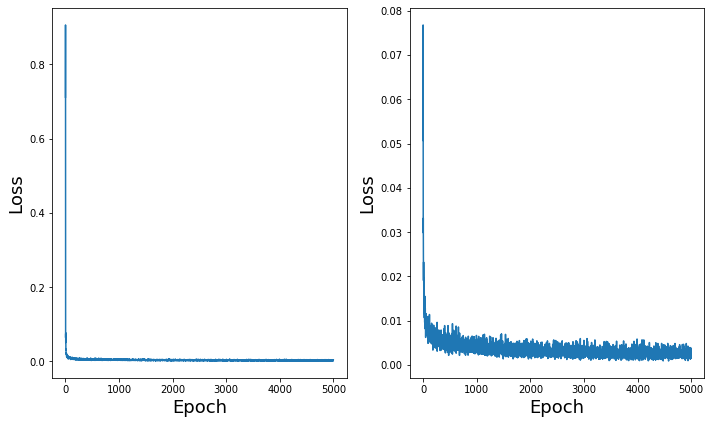

In [7]:
if train_bool:
    # Plot the loss function
    fig, axes = plt.subplots(1, 2, figsize=(10, 6))
    axes[0].plot(loss_hist)
    axes[0].set_xlabel('Epoch', fontsize=label_font)
    axes[0].set_ylabel('Loss', fontsize=label_font)
    axes[1].plot(loss_hist[5:])
    axes[1].set_xlabel('Epoch', fontsize=label_font)
    axes[1].set_ylabel('Loss', fontsize=label_font)
    fig.tight_layout();


In [8]:
# torch.save(classic_net.state_dict(), 'trained_N9_continual_learning_wt_pass.pt')

# https://stackoverflow.com/questions/42703500/best-way-to-save-a-trained-model-in-pytorch
# https://pytorch.org/tutorials/beginner/saving_loading_models.html


0 0.0004339052247814834


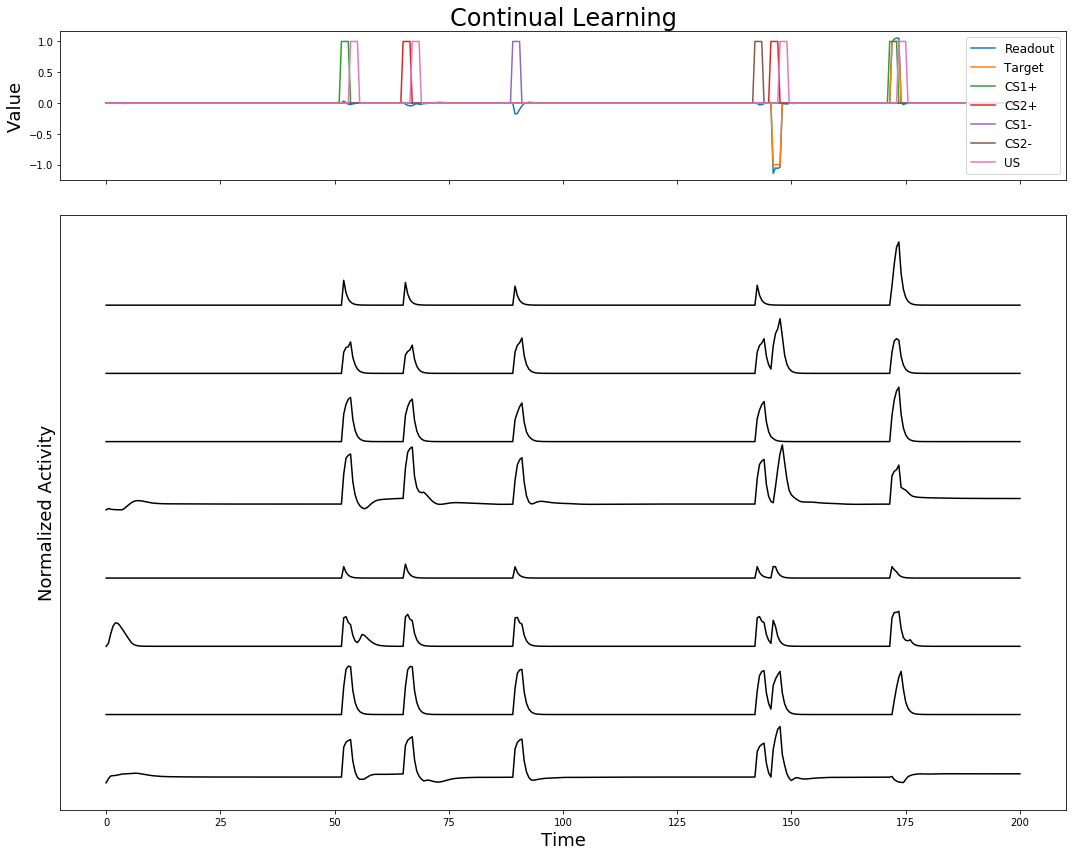

In [9]:
# Plot some results to compare to Fig 2A/B in paper
if not train_bool:
    classic_net.load_state_dict(torch.load('trained_N9_continual_learning_wt_pass.pt'))
    classic_net.eval()

print_trial(classic_net)
# if train_task == 'first-order':
#     print_trial(classic_net, task1=train_task, task2='CS+')
#     print_trial(classic_net, task1=train_task, task2='CS-')
# elif train_task == 'all_tasks':
#     print_trial(classic_net, task1=train_task, task2='extinct')
#     print_trial(classic_net, task1=train_task, task2='CS2')


In [10]:
# r_out, Wt, vt, vt_opt, loss_hist, _ = train_net(classic_net, task=train_task, n_epochs=200, train=False)
# r_out, Wt, vt, vt_opt, loss_hist, _ = classic_net.train_net(opti=optimizer, n_epoch=100)
r_out, vt, vt_opt, loss_hist, _ = classic_net.train_net(opti=optimizer, n_epoch=200)
print(np.mean(loss_hist), np.std(loss_hist))


0 0.0022598495706915855
0.0024703832058003174 0.000742652914845484
